# Sea ice break-up date evaluation with satellite remote sending data

- ASMR data

## Setup

In [1]:
import xarray as xr
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdate
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
from matplotlib.lines import Line2D
from matplotlib.ticker import LogLocator
import matplotlib.patches as mpatches

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns

from datetime import datetime, timedelta

from glob import glob 

from sys import path as syspath
syspath.append('../')
import mapPlots as mplt

%load_ext autoreload
%autoreload 2

In [2]:
save_dir = '/home/pfarnole/data/sibd/'
sat = xr.open_mfdataset(f'{save_dir}ASMR/*.nc').sibd50.drop_sel(year=range(2016,2020)).chunk(dict(year=-1))
mdl = xr.open_mfdataset(f'{save_dir}DFS/*nc').sibd50.drop_sel(year=2012).chunk(dict(year=-1))
mdl_regrid= xr.open_mfdataset(f'{save_dir}DFS_regto_ASMR_2003_2015.nc').sibd50.squeeze().drop_sel(year=2012).chunk(dict(year=-1))

In [13]:
sat


<xarray.DataArray 'sibd50' (year: 12, y: 1792, x: 1216)>
dask.array<rechunk-merge, shape=(12, 1792, 1216), dtype=float64, chunksize=(12, 1792, 1216), chunktype=numpy.ndarray>
Coordinates:
    lon      (y, x) float64 dask.array<chunksize=(1792, 1216), meta=np.ndarray>
    lat      (y, x) float64 dask.array<chunksize=(1792, 1216), meta=np.ndarray>
  * year     (year) int64 2003 2004 2005 2006 2007 ... 2010 2011 2013 2014 2015
Dimensions without coordinates: y, x

In [14]:
mdl_regrid

<xarray.DataArray 'sibd50' (year: 12, y: 1792, x: 1216)>
dask.array<getitem, shape=(12, 1792, 1216), dtype=float64, chunksize=(12, 1792, 1216), chunktype=numpy.ndarray>
Coordinates:
  * year     (year) int64 2003 2004 2005 2006 2007 ... 2010 2011 2013 2014 2015
    lat      (y, x) float64 dask.array<chunksize=(1792, 1216), meta=np.ndarray>
    lon      (y, x) float64 dask.array<chunksize=(1792, 1216), meta=np.ndarray>
Dimensions without coordinates: y, x

## Plot climatologies

In [3]:
mdl_clim=mdl.mean(dim='year').compute()
mdl_regrid_clim=mdl_regrid.mean(dim='year').compute()
sat_clim=sat.mean(dim='year').compute()
# number of years where SI break-up is defined
mdl_nyears = xr.where(mdl.isnull(),0,1).sum('year').compute()
mdl_regrid_nyears = xr.where(mdl_regrid.isnull(),0,1).sum('year').compute()
sat_nyears = xr.where(sat.isnull(),0,1).sum('year').compute()


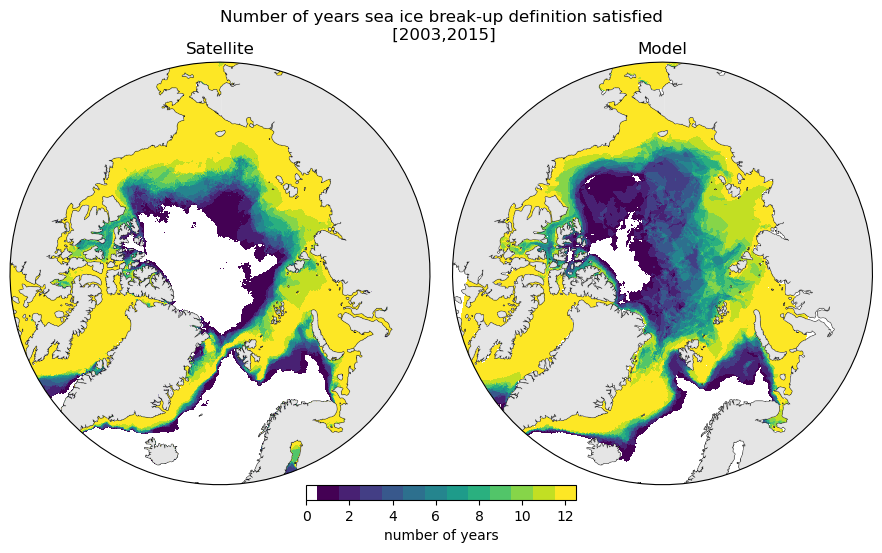

In [4]:
fig,ax = mplt.initmaps(1,2,figsize=(9,5),rnd=True,extent=[-180,180, 62,90])
fig.suptitle(f'Number of years sea ice break-up definition satisfied\n [2003,2015]')#,fontsize=10)
fig.tight_layout()
# fig.subplots_adjust(hspace=0.05,wspace=-0)

ax[0].set_title(f'Satellite')
pl= ax[0].pcolormesh(sat_nyears.lon, sat_nyears.lat, sat_nyears.where(sat_nyears>0),
                    vmin=0.5,vmax=12.5, cmap = plt.get_cmap('viridis',12),
                    transform=ccrs.PlateCarree()
)
# ax[0].add_feature(cfeature.LAND, zorder=1, facecolor=[1,1,1])

ax[1].set_title(f'Model')
pl= ax[1].pcolormesh(mdl_nyears.lon, mdl_nyears.lat, mdl_nyears.where(mdl_nyears>0),
                    vmin=0.5,vmax=12.5, cmap = plt.get_cmap('viridis',12),
                    transform=ccrs.PlateCarree()
)

cbar_ax = fig.add_axes([0.5-0.15, 0., 0.3, 0.03])                               
cl = fig.colorbar(pl,cax=cbar_ax, extend=None, orientation='horizontal', shrink=0.4)
cl.set_label('number of years')
cl.set_ticks(range(0,13,2))


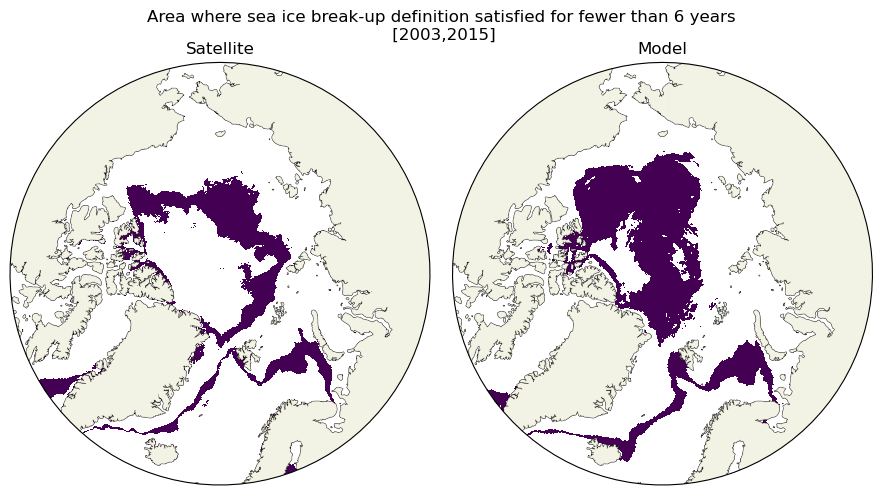

In [5]:
ny=6

fig,ax = mplt.initmaps(1,2,figsize=(9,5),rnd=True,extent=[-180,180, 62,90])
fig.suptitle(f'Area where sea ice break-up definition satisfied for fewer than {ny} years\n [2003,2015]')#,fontsize=10)
fig.tight_layout()
# fig.subplots_adjust(hspace=0.05,wspace=-0)

ax[0].set_title(f'Satellite')
pl= ax[0].pcolormesh(sat_nyears.lon, sat_nyears.lat, xr.where((sat_nyears>0) & (sat_nyears<ny),1,np.nan),
                    transform=ccrs.PlateCarree()
)

ax[1].set_title(f'Model')
pl= ax[1].pcolormesh(mdl_nyears.lon, mdl_nyears.lat, xr.where((mdl_nyears>0) & (mdl_nyears<ny),1,np.nan),
                    transform=ccrs.PlateCarree()
)


In [4]:
def pltwithhatch(ax,lon,lat,var,
                 hatchMsk, hatchColor='k', hatchlw=0.1, noHatchNan=True, hatchStyle='xxx',
                 **pltkw):
    # plot variable 
    pl=ax.pcolormesh(lon, lat, var, transform=ccrs.PlateCarree(), **pltkw)

    plt.rcParams.update({'hatch.color': hatchColor, 'hatch.linewidth': hatchlw})
    ax.contourf(lon, lat, hatchMsk, 
                levels=[0.5,1], colors='none', hatches=[hatchStyle]*2,
                transform_first=True, transform=ccrs.PlateCarree(),
    )
    return pl

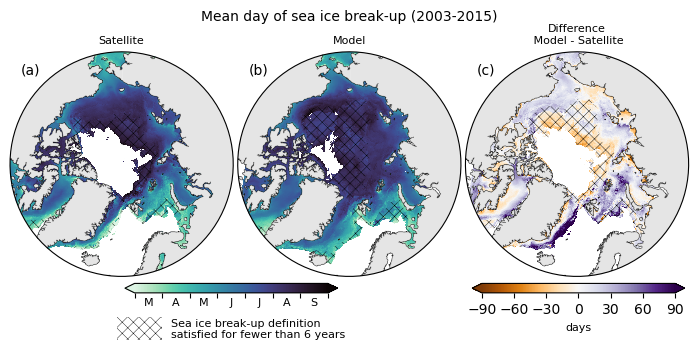

In [10]:
hc='k'
hlw=0.3
ny=6

fig,ax = mplt.initmaps(1,3,figsize=(18/2.54,8/2.54),rnd=True,extent=[-180,180, 62,90])
fig.suptitle(f'Mean day of sea ice break-up (2003-2015)', fontsize=10)
fig.tight_layout()
fig.subplots_adjust(top=0.93,wspace=0.02)

ltr=['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
for il,a in enumerate(fig.axes): a.text(0.05,0.9,f'({ltr[il]})',transform=a.transAxes)


ax[0].set_title(f'Satellite',fontsize=8)
pl= pltwithhatch(ax[0],sat.lon, sat.lat, sat_clim,
                 hatchMsk=((sat_nyears>0) & (sat_nyears<ny)), hatchColor=hc, hatchlw=hlw,
                 vmin=60,vmax=270, cmap = sns.color_palette("mako_r", as_cmap=True),
)

ax[1].set_title(f'Model',fontsize=8)
pl= pltwithhatch(ax[1],mdl_regrid.lon, mdl_regrid.lat, mdl_regrid_clim,
                 hatchMsk=((mdl_regrid_nyears>0) & (mdl_regrid_nyears<ny) ), 
                 hatchColor=hc, hatchlw=hlw,
                 vmin=60,vmax=270, cmap = sns.color_palette("mako_r", as_cmap=True),
)

cbar_ax = fig.add_axes([1/3-0.15, 0.08, 0.3, 0.03])                               
cl = fig.colorbar(pl,cax=cbar_ax, extend='both', orientation='horizontal', shrink=0.4)
# cl.set_label('day of year')
cl.set_ticks(range(60,271,30),labels=[])
cl.set_ticks(range(75,271,30),labels=['M','A','M','J','J','A','S'],minor=True, fontsize=8)
cbar_ax.tick_params(axis='x', which='minor', length=0)

leg = cbar_ax.legend(loc='lower center', bbox_to_anchor=(0.5, -6), handlelength=4, frameon=False, fontsize=8,
        handles=[mpatches.Patch(facecolor='w',hatch=r'xxx',label=f'Sea ice break-up definition\nsatisfied for fewer than {ny} years')])
leg.get_patches()[0].set_height(16)
leg.get_patches()[0].set_y(-5)



ax[2].set_title(f'Difference\n Model - Satellite',fontsize=8)
pl= pltwithhatch(ax[2],sat.lon, sat.lat, mdl_regrid_clim-sat_clim,
                 hatchMsk=(((mdl_regrid_nyears>0) & (mdl_regrid_nyears<ny))|((sat_nyears>0) & (sat_nyears<ny))) & (sat_clim-mdl_regrid_clim<1000) , 
                 hatchColor=hc, hatchlw=hlw,
                 vmin=-90,vmax=90, cmap ='PuOr',
)

cbar_ax = fig.add_axes([2/3+1/6-0.16, 0.08, 0.3, 0.03])                               
cl = fig.colorbar(pl,cax=cbar_ax, extend='both', orientation='horizontal', shrink=0.4)
cl.set_label('days',fontsize=8)
cl.set_ticks(range(-90,91,30))

plt.savefig(f'../figs/IAphenology23/SIbreak-mean-eval-90dpi.png',bbox_inches='tight',dpi=90)
plt.savefig(f'../figs/IAphenology23/SIbreak-mean-eval-300dpi.png',bbox_inches='tight',dpi=300)


## Median

In [23]:
mdl_med=mdl.median(dim='year').compute()
mdl_regrid_med=mdl_regrid.median(dim='year').compute()
sat_med=sat.median(dim='year').compute()

/home/ahaddon/miniconda3/envs/xr/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/home/ahaddon/miniconda3/envs/xr/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/home/ahaddon/miniconda3/envs/xr/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


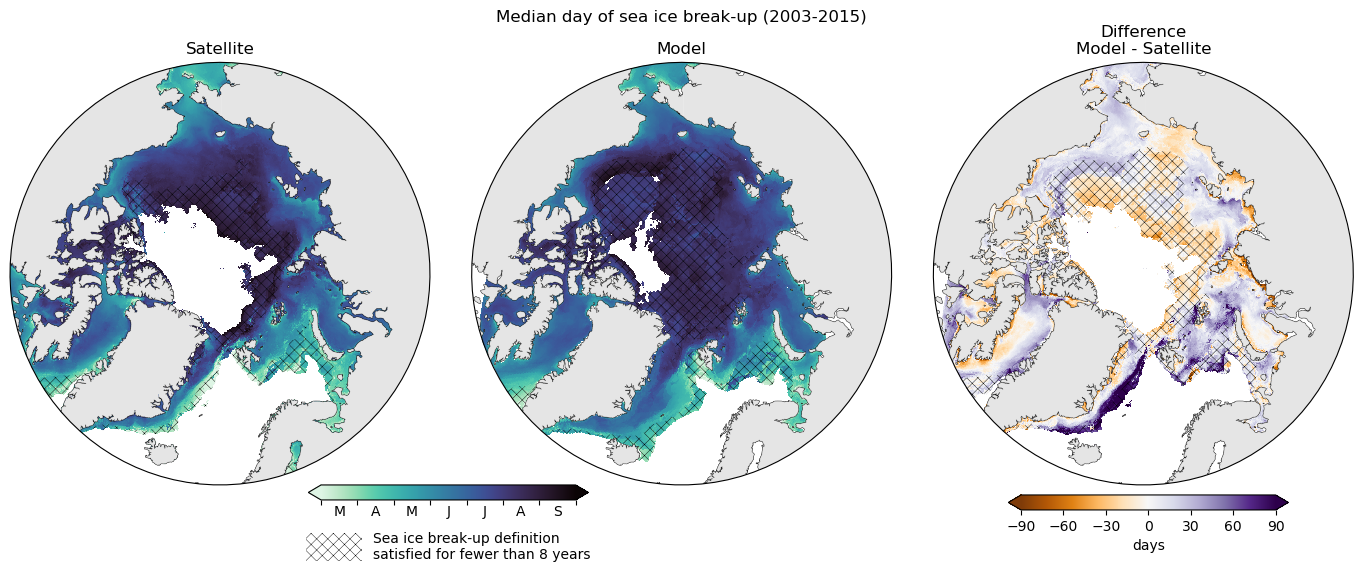

In [27]:
hc='k'
hlw=0.3
ny=8

fig,ax = mplt.initmaps(1,3,figsize=(14,5),rnd=True,extent=[-180,180, 62,90])
fig.suptitle(f'Median day of sea ice break-up (2003-2015)\n')
fig.tight_layout()

ax[0].set_title(f'Satellite')
pl= pltwithhatch(ax[0],sat.lon, sat.lat, sat_med,
                 hatchMsk=((sat_nyears>0) & (sat_nyears<ny)), hatchColor=hc, hatchlw=hlw,
                 vmin=60,vmax=270, cmap = sns.color_palette("mako_r", as_cmap=True),
)

ax[1].set_title(f'Model')
pl= pltwithhatch(ax[1],mdl_regrid.lon, mdl_regrid.lat, mdl_regrid_med,
                 hatchMsk=((mdl_regrid_nyears>0) & (mdl_regrid_nyears<ny) ), 
                 hatchColor=hc, hatchlw=hlw,
                 vmin=60,vmax=270, cmap = sns.color_palette("mako_r", as_cmap=True),
)


cbar_ax = fig.add_axes([1/3-0.1, 0., 0.2, 0.03])                               
cl = fig.colorbar(pl,cax=cbar_ax, extend='both', orientation='horizontal', shrink=0.4)
# cl.set_label('day of year')
cl.set_ticks(range(60,271,30),labels=[])
cl.set_ticks(range(75,271,30),labels=['M','A','M','J','J','A','S'],minor=True)
cbar_ax.tick_params(axis='x', which='minor', length=0)

leg = cbar_ax.legend(loc='lower center', bbox_to_anchor=(0.5, -5), handlelength=4, frameon=False,
        handles=[mpatches.Patch(facecolor='w',hatch=r'xxx',label=f'Sea ice break-up definition\nsatisfied for fewer than {ny} years')])
leg.get_patches()[0].set_height(20)
leg.get_patches()[0].set_y(-6)



ax[2].set_title(f'Difference\nModel - Satellite')
pl= pltwithhatch(ax[2],sat.lon, sat.lat, mdl_regrid_med-sat_med,
                 hatchMsk=(((mdl_regrid_nyears>0) & (mdl_regrid_nyears<ny))|((sat_nyears>0) & (sat_nyears<ny))) & (sat_med-mdl_regrid_med<1000) , 
                 hatchColor=hc, hatchlw=hlw,
                 vmin=-90,vmax=90, cmap ='PuOr',
)

cbar_ax = fig.add_axes([2/3+1/6-0.1, -0.02, 0.2, 0.03])                               
cl = fig.colorbar(pl,cax=cbar_ax, extend='both', orientation='horizontal', shrink=0.4)
cl.set_label('days')
cl.set_ticks(range(-90,91,30))



## Variability : inter quantile range

In [5]:
mdl_regrid_interQ=(mdl_regrid.quantile(0.75,dim='year') - mdl_regrid.quantile(0.25,dim='year')).compute()
sat_interQ=(sat.quantile(0.75,dim='year') - sat.quantile(0.25,dim='year')).compute()

/home/ahaddon/miniconda3/envs/xr/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/ahaddon/miniconda3/envs/xr/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


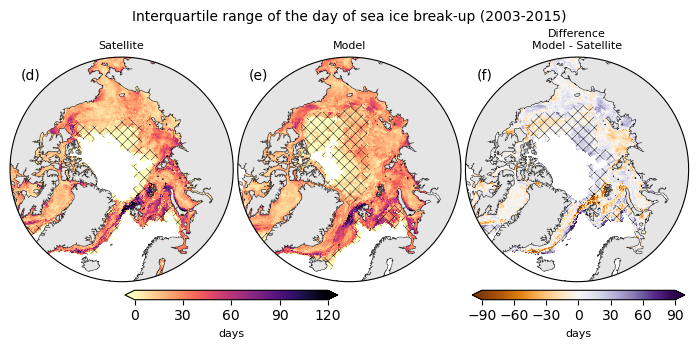

In [6]:
hc='k'
hlw=0.3
ny=6

fig,ax = mplt.initmaps(1,3,figsize=(18/2.54,8/2.54),rnd=True,extent=[-180,180, 62,90])
fig.suptitle(f'Interquartile range of the day of sea ice break-up (2003-2015)\n',fontsize=10)
fig.tight_layout()
fig.subplots_adjust(top=0.9,wspace=0.02)

ltr=['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
for il,a in enumerate(fig.axes): a.text(0.05,0.9,f'({ltr[il+3]})',transform=a.transAxes)

ax[0].set_title(f'Satellite',fontsize=8)
pl= pltwithhatch(ax[0],sat.lon, sat.lat, sat_interQ,
                 hatchMsk=((sat_nyears>0) & (sat_nyears<ny)), hatchColor=hc, hatchlw=hlw,
                 vmin=0,vmax=120, cmap = sns.color_palette("magma_r", as_cmap=True),
)

ax[1].set_title(f'Model',fontsize=8)
pl= pltwithhatch(ax[1],mdl_regrid.lon, mdl_regrid.lat, mdl_regrid_interQ,
                 hatchMsk=((mdl_regrid_nyears>0) & (mdl_regrid_nyears<ny) ), 
                 hatchColor=hc, hatchlw=hlw,
                 vmin=0,vmax=120, cmap = sns.color_palette("magma_r", as_cmap=True),
)


cbar_ax = fig.add_axes([1/3-0.15, 0.06, 0.3, 0.03])                               
cl = fig.colorbar(pl,cax=cbar_ax, extend='both', orientation='horizontal', shrink=0.4)
cl.set_label('days',fontsize=8)
cl.set_ticks(range(0,121,30))

# leg = cbar_ax.legend(loc='lower center', bbox_to_anchor=(0.5, -8), handlelength=4, frameon=False,fontsize=8,
#         handles=[mpatches.Patch(facecolor='w',hatch=r'xxx',label=f'Sea ice break-up definition\nsatisfied for fewer than {ny} years')])
# leg.get_patches()[0].set_height(16)
# leg.get_patches()[0].set_y(-5)



ax[2].set_title(f'Difference\nModel - Satellite',fontsize=8)
pl= pltwithhatch(ax[2],sat.lon, sat.lat, mdl_regrid_interQ - sat_interQ,
                 hatchMsk=(((mdl_regrid_nyears>0) & (mdl_regrid_nyears<ny))|((sat_nyears>0) & (sat_nyears<ny))) & (sat_interQ-mdl_regrid_interQ<1000) , 
                 hatchColor=hc, hatchlw=hlw,
                 vmin=-90,vmax=90, cmap ='PuOr',
)

cbar_ax = fig.add_axes([2/3+1/6-0.16, 0.06, 0.3, 0.03])                               
cl = fig.colorbar(pl,cax=cbar_ax, extend='both', orientation='horizontal', shrink=0.4)
cl.set_label('days',fontsize=8)
cl.set_ticks(range(-90,91,30))

plt.savefig(f'../figs/IAphenology23/SIbreak-interQ-eval-90dpi.png',bbox_inches='tight',dpi=90)
plt.savefig(f'../figs/IAphenology23/SIbreak-interQ-eval-300dpi.png',bbox_inches='tight',dpi=300)


- Overall model sea ice break up is late in Beaufort, Chukchi, Bering,  Barents, GIN
- model is early only central arctic (but few years with break up) west of baffin, small areas of CAA
- E. Sibera and Laptev both early and late, depends on years
- GIN barents : strong variability, 
- best in CAA
- central arctic: area with never break up larger in satellite, but generaly area with no break up large in model

General
- spatial patterns resolved resonably well but patterns shifted, precise location not accuarate
- similar gradient reproduced from ice edge to interior and from perinal ice zone to seasonal ice zone
- larger errors because not resolving ice edge spatial location or perinial ice zone (area with non break-up)
- in GIN and Barents, error > 2 months because ice edge not resolved acuratly, but sea ice edge breaks up in march in both satellite and model